<a href="https://colab.research.google.com/github/nikhelll/Finance-Tidbits/blob/main/Pairs_Trading_OU_Process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

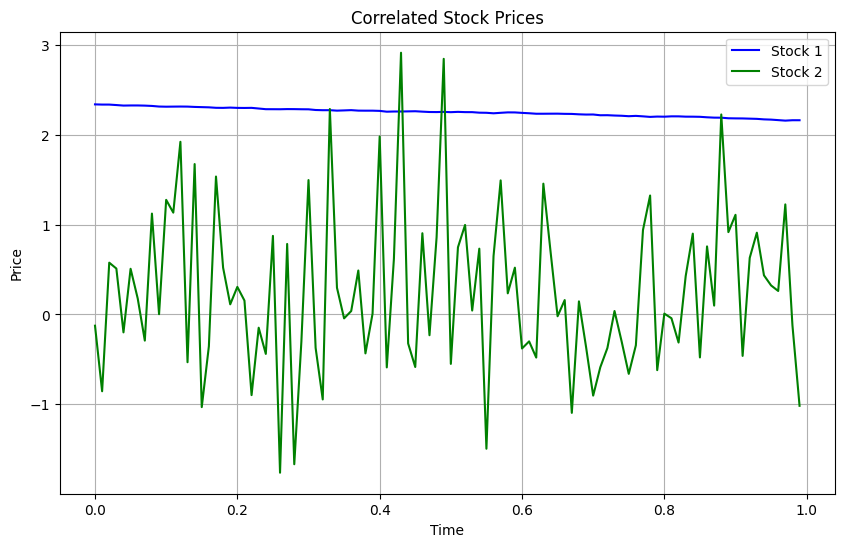

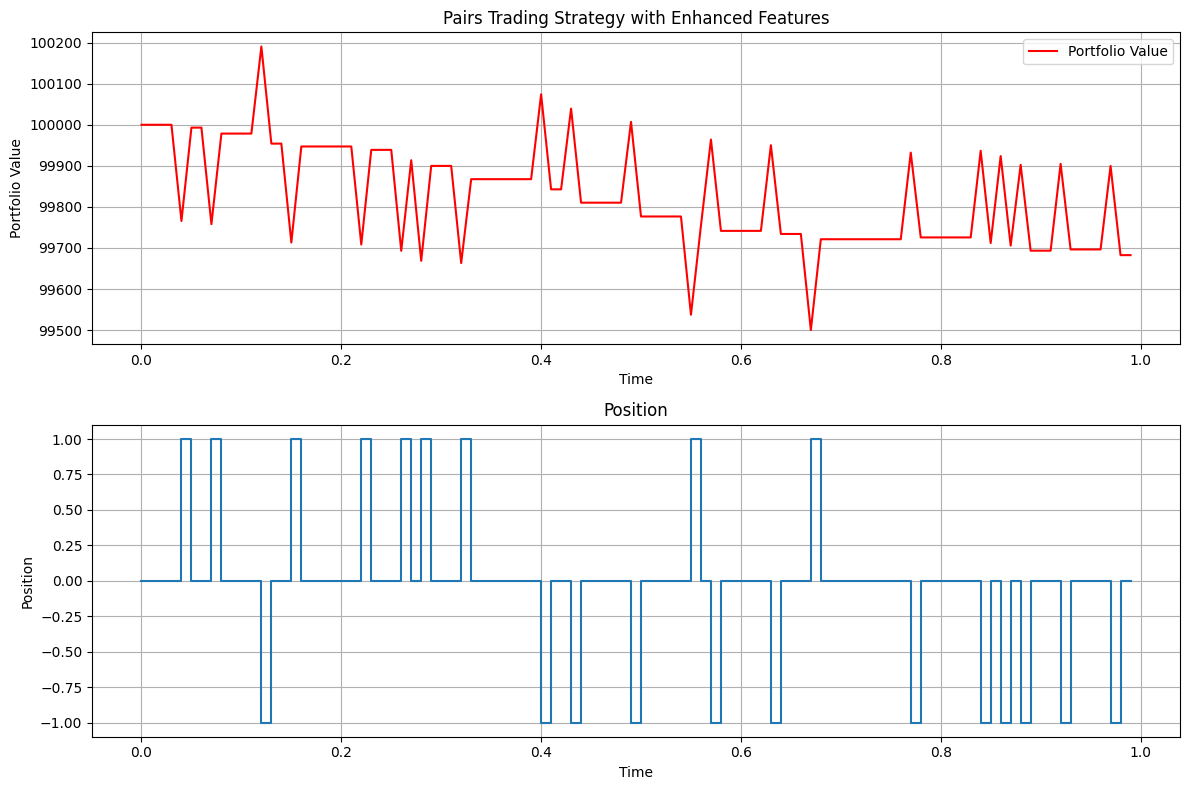

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Function to simulate the Ornstein-Uhlenbeck process
def ornstein_uhlenbeck_process(theta, mu, sigma, dt, N):
    x = np.zeros(N)
    x[0] = np.random.normal(0, 1)  # Initial value sampled from a standard normal distribution

    for i in range(1, N):
        dx = theta * (mu - x[i - 1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1)
        x[i] = x[i - 1] + dx

    return x

# Parameters for the Ornstein-Uhlenbeck process
theta = 0.1   # Mean reversion speed
mu = 0.2      # Long-term mean
sigma = 0.03  # Volatility
dt = 0.01     # Time step
T = 1         # Total time
N = int(T / dt)  # Number of time steps

# Simulate the Ornstein-Uhlenbeck process
x1 = ornstein_uhlenbeck_process(theta, mu, sigma, dt, N)
x2 = theta * x1 + (1 - theta) * np.random.normal(0, 1, N)

# Pairs trading strategy based on relative prices
spread = x1 - theta * x2  # Calculate the spread between the two stock prices

# Trading signals
z_score = (spread - np.mean(spread)) / np.std(spread)  # Calculate the z-score of the spread
entry_threshold = 1.0  # Entry threshold for a long-short position
exit_threshold = 0.5   # Exit threshold for closing the position

# Trading simulation with enhanced features
num_shares = 100        # Number of shares to trade
cash = 100000           # Initial capital
portfolio = [cash] * N  # Initialize portfolio list with the initial cash value for each time step
positions = [0] * N     # Initialize positions list with zeros for each time step
trade_executed = [0]    # Initialize trade_executed list with 0 for the first time step

stop_loss = -0.05       # Stop-loss level
take_profit = 0.05      # Take-profit level

for i in range(1, len(z_score)):
    # Check if there is an open position
    if positions[i - 1] != 0:
        # Check for stop-loss or take-profit conditions
        if positions[i - 1] == 1 and (spread[i] < stop_loss or spread[i] > take_profit):
            cash += positions[i - 1] * num_shares * x1[i]  # Close long position
            cash -= theta * positions[i - 1] * num_shares * x2[i]  # Close short position
            positions[i] = 0
            trade_executed.append(i)
        elif positions[i - 1] == -1 and (spread[i] > -stop_loss or spread[i] < -take_profit):
            cash += positions[i - 1] * num_shares * x1[i]  # Close short position
            cash -= theta * positions[i - 1] * num_shares * x2[i]  # Close long position
            positions[i] = 0
            trade_executed.append(i)
        else:
            positions[i] = positions[i - 1]  # Keep the existing position
            trade_executed.append(trade_executed[-1])  # Keep the last trade executed value
    else:
        # Check for entry conditions
        if z_score[i] > entry_threshold and z_score[i - 1] <= entry_threshold:
            # Enter long-short position
            cash -= num_shares * x1[i]  # Short stock 1
            cash += theta * num_shares * x2[i]  # Long stock 2
            positions[i] = 1
            trade_executed.append(i)
        elif z_score[i] < -entry_threshold and z_score[i - 1] >= -entry_threshold:
            # Enter short-long position
            cash += num_shares * x1[i]  # Long stock 1
            cash -= theta * num_shares * x2[i]  # Short stock 2
            positions[i] = -1
            trade_executed.append(i)
        else:
            positions[i] = 0  # No position
            trade_executed.append(trade_executed[-1])  # Keep the last trade executed value

    portfolio[i] = cash

# Plot the two time series
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0, T, dt), x1, label='Stock 1', color='blue')
plt.plot(np.arange(0, T, dt), x2, label='Stock 2', color='green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Correlated Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

# Plot the portfolio value and positions over time
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0, T, dt), portfolio, label='Portfolio Value', color='red')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Pairs Trading Strategy with Enhanced Features')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.step(np.arange(0, T, dt), positions, where='post')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Position')
plt.grid(True)

plt.tight_layout()
plt.show()